In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, RocCurveDisplay, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
import scipy.stats as stats

# Set editable pdf font
plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=1.5)

In [5]:
def BalancedRandForestCv(X, y, classifier, title='a title', n_splits=4, pos_label=1, random_state_seed=0, pdfOut=False):
    # Define folds for cross-validation
    cv = StratifiedKFold(n_splits=n_splits, random_state=random_state_seed, shuffle=True)
    # Collection of performance metrics
    conf_m, accuracy, f1 = [], [], []
    # ROC curve measurements collection
    tprs, aucs, mean_fpr = [], [], np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    for train, test in cv.split(X, y):
        classifier.fit(X[train], y[train])
        # Get metrics for each fold
        y_pred = classifier.predict(X[test])
        conf_m.append(confusion_matrix(y[test], y_pred, labels=[0, 1]))
        accuracy.append(accuracy_score(y[test], y_pred))
        f1.append(f1_score(y[test], y_pred))
        # ROC curve  
        viz = RocCurveDisplay.from_estimator(classifier, X[test], y[test], ax=ax, alpha=.7, lw=1, color='grey', pos_label=pos_label, response_method='predict_proba')
        tprs.append(np.interp(mean_fpr, viz.fpr, viz.tpr))
        aucs.append(viz.roc_auc)
    # Compute and plot mean ROC curve with sd
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    ax.plot(mean_fpr, mean_tpr, color='#B9529F', lw=3, alpha=0.8, label=f"Mean ROC (AUC = {auc(mean_fpr, mean_tpr):.2f} ± {np.std(aucs):.2f})")
    ax.fill_between(mean_fpr, np.maximum(mean_tpr - np.std(tprs, axis=0), 0), np.minimum(mean_tpr + np.std(tprs, axis=0), 1), color='#B9529F', alpha=0.2, label="± 1 std. dev.",)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    # Add labels and legend
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=f"{title}\nmean ROC (n folds = {n_splits})")
    # Add legend, but remove RandomForestCLassifier from it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[-2:], labels=labels[-2:], loc='lower right')
    plt.show()
    if pdfOut:
        fig.savefig(pdfOut, bbox_inches='tight')
    return {'confusion matrices': conf_m, 'Accuracy': accuracy, 'F1-score' : f1, 'AUC': aucs}


def EvaluateAucImprovementWithFeatAddition(currentAuc, selected_features, remaining_features, X, y, balanced_classifier, c, outpath='.', kfold=4):
    # Initialise an empty list to store the best new feature set
    best_new_feature = []
    best_new_auc = currentAuc
    # Evaluate adding each remaining feature
    resultDict = {}
    print('selected_features: ', selected_features)
    print('remaining_features: ', remaining_features)
    for feature in remaining_features:
        print(f"Adding feature: {feature}")
        # Corrected the issue here: create a new list by copying selected_features and then appending the feature
        featSet = selected_features.copy()
        featSet.append(feature)
        print(featSet)
        featSetName = ' / '.join(featSet)
        featFileName = '_'.join(featSet)
        Xt = X[featSet]
        # Train the model with the new feature set
        result = BalancedRandForestCv(Xt.values, y.values, balanced_classifier, n_splits=kfold, title=f"Classification performance: {c} - {featSetName}", pdfOut=f'{outpath}ROC-{featFileName}.pdf')
        resultDict[featSetName] = result
        mean_auc = np.mean(result['AUC'])
        # Evaluate improvement in AUC
        if mean_auc > best_new_auc:
            best_new_auc = mean_auc
            best_new_feature = featSet
    return best_new_feature, best_new_auc, resultDict

## Data

In [6]:
# Load data #1

# Parameters
ctrlmaxlfc = 0.1
pCutoff = 0.05
kfold = 4

# Sequence features
dfSeqFeatsFull = pd.read_csv('../results/ModelDatasets/GermBasedKmerClustersMvScores.tsv.gz', sep='\t', compression='gzip')
# K-mer clusters
dfKmerClusters = pd.read_csv('../results/general/release_GermRegionBasedKmerClusters.tsv', sep='\t')
dfKmerClusters.rename(columns={'GermBasedCluster': 'Cluster'}, inplace=True)
# Load raw k-mer multivalency - we will use these to handle co-linear clusters and then scale
dfCorr = dfSeqFeatsFull.pivot(index='gene_id', columns='Cluster', values='StandardScaled_LengthNorm_MVScoreSum (per kb)').fillna(0)
# Transcript features
dfTxInfoIn= pd.read_csv(f'../results/ModelDatasets/2023-Faraway_TranscriptInfo.tsv', sep='\t', index_col=0)
# nuc / cyto ratio
lfcCol='log2FoldChange_Rupert_PPIG_nuc.cyt_ratios'
padjCol='padj_Rupert_PPIG_nuc.cyt_ratios'
NucCyto = pd.read_csv('../data/out_compiled_tx_features.txt', sep='\t', low_memory=False).set_index('gene_id')
# Change groups 3-6 to NaN
NucCyto.loc[NucCyto.groups_classes.isin([f'group{i}' for i in range(3,7)]), 'groups_classes'] = np.nan
# Make output directory
outpath = '../results/BalancedRandomForest_PPIG_GermBasedFeats/'
os.makedirs(outpath, exist_ok=True)

## Sequence features engineering

/home/klara/conda/envs/interstasis_paper/lib/python3.13/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

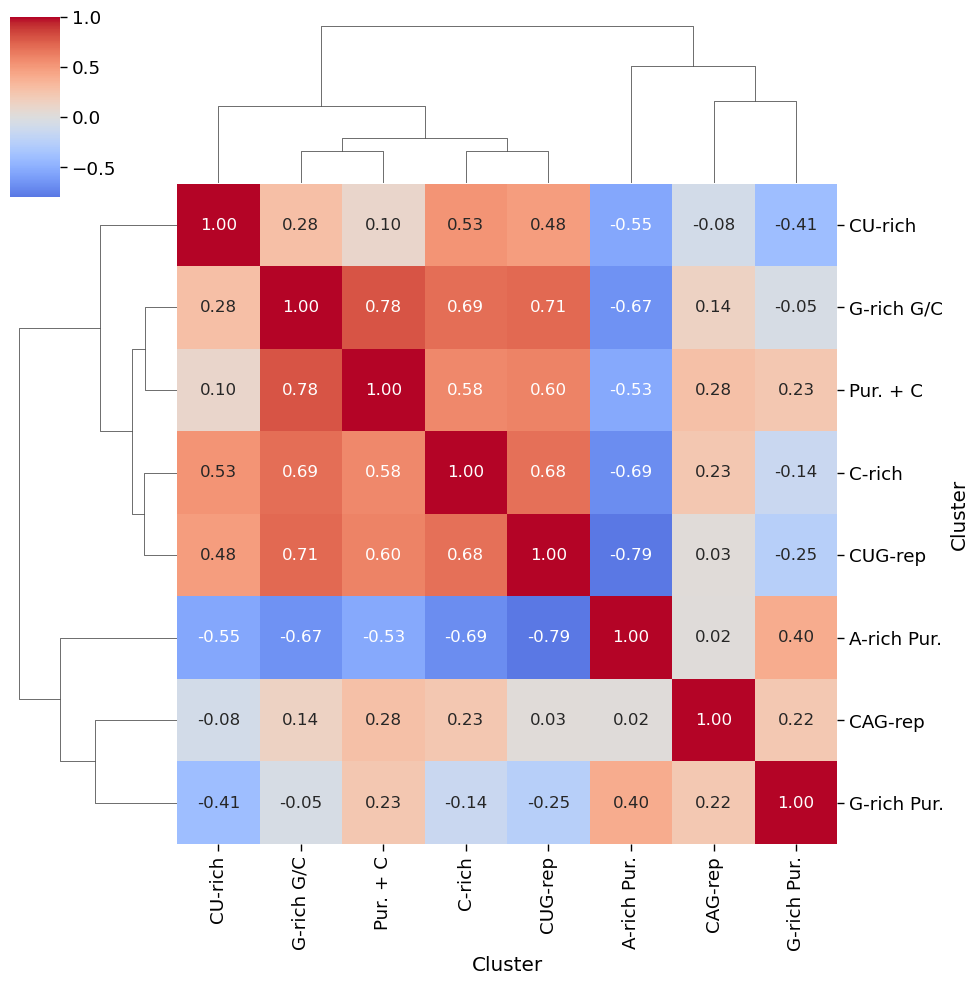

In [7]:
# Plot correlation matrix, use spearman rank
corr = dfCorr.corr(method='spearman')
plt.figure(figsize=(12, 10))
sns.clustermap(corr, cmap='coolwarm', center=0, square=True, annot=True, annot_kws={'size': 12}, fmt=".2f")

In [8]:
# Take total k-mer multivalency per gene and summarise G-rich G/C, Pur. + C into -> Pur + C; C-rich, CUG-rich, CU-rich into -> C/CU/CUG-rich
gc_rich = ['C-rich', 'CUG-rep', 'G-rich G/C', 'Pur. + C']
dfSeqFeatsFull.loc[dfSeqFeatsFull.Cluster.isin(gc_rich), 'Cluster'] = 'GC-rich'
# Groupby gene_id, cds_length and Cluster and sum k-mer multivalency
dfSeqFeatsFull = dfSeqFeatsFull.groupby(['gene_id', 'cds_length', 'Cluster']).sum()['RawMVScoreSum'].reset_index()
# Calculate length normalised k-mer multivalency and standard scale it within cluster
dfSeqFeatsFull['LengthNorm_MVScoreSum (per kb)'] = dfSeqFeatsFull['RawMVScoreSum'] * 1000 / dfSeqFeatsFull['cds_length']
# Scale k-mer multivalency within cluster
scaler = StandardScaler()
dfSeqFeatsFull['StandardScaled_LengthNorm_MVScoreSum (per kb)'] = dfSeqFeatsFull.groupby('Cluster')['LengthNorm_MVScoreSum (per kb)'].transform(lambda x: scaler.fit_transform(x.values[:,np.newaxis]).ravel())
# Pivot table - take only scaled k-mer multivalency
dfSeqFeats = dfSeqFeatsFull.pivot(index='gene_id', columns='Cluster', values='StandardScaled_LengthNorm_MVScoreSum (per kb)').fillna(0)
# Rename  G-rich Pur. to GA-rich, A-rich Pur. to A-rich
dfSeqFeats.rename(columns={'G-rich Pur.': 'GA-rich', 'A-rich Pur.': 'A-rich'}, inplace=True)

In [9]:
# Combine and rename k-mer clusters accordingly
dfKmerClusters.loc[dfKmerClusters.Cluster.isin(gc_rich), 'Cluster'] = 'GC-rich'
dfKmerClusters.Cluster = dfKmerClusters.Cluster.str.replace('G-rich Pur.', 'GA-rich').str.replace('A-rich Pur.', 'A-rich')
# Sort by cluster and save
dfKmerClusters.sort_values('Cluster').to_csv(f'{outpath}SourceData_GermRegionBasedKmerClusters.tsv', sep='\t', index=False)

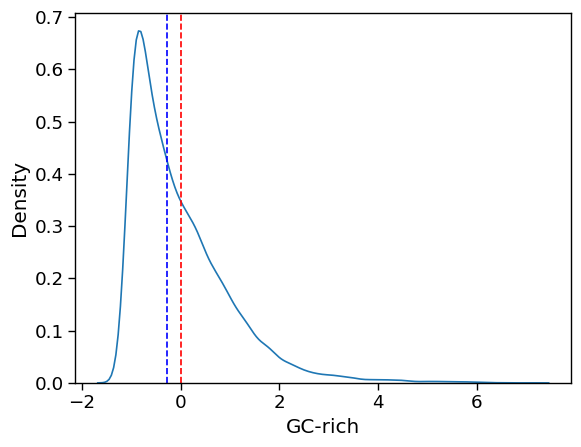

In [10]:
# Plot standard scaled distribution for GC-cluster
sns.kdeplot(dfSeqFeats['GC-rich'])
# Plot line at the mean
plt.axvline(dfSeqFeats['GC-rich'].mean(), color='red', linestyle='--')
# Plot line at the median
plt.axvline(dfSeqFeats['GC-rich'].median(), color='blue', linestyle='--')

In [11]:
dfSeqFeats

Cluster,A-rich,CAG-rep,CU-rich,GA-rich,GC-rich
gene_id,,,,,
ENSG00000000003,-0.113790,-0.766382,-0.468040,-0.510049,-1.048433
ENSG00000000005,1.123489,-0.356301,-0.759738,0.366505,-1.009598
ENSG00000000419,0.649422,-0.636088,-0.233420,-0.225227,-0.833631
ENSG00000000457,0.071981,-0.222993,-0.296458,0.156547,-0.805541
ENSG00000000460,-0.184347,-0.481069,0.138026,-0.558829,-0.869602
...,...,...,...,...,...
ENSG00000285458,0.822350,-0.438207,-0.069084,-0.419428,-0.995451
ENSG00000285472,-0.649233,-0.490686,2.235975,-0.563329,-0.814258
ENSG00000285551,0.075519,-0.202624,-0.137757,-0.779395,-0.741220


/home/klara/conda/envs/interstasis_paper/lib/python3.13/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

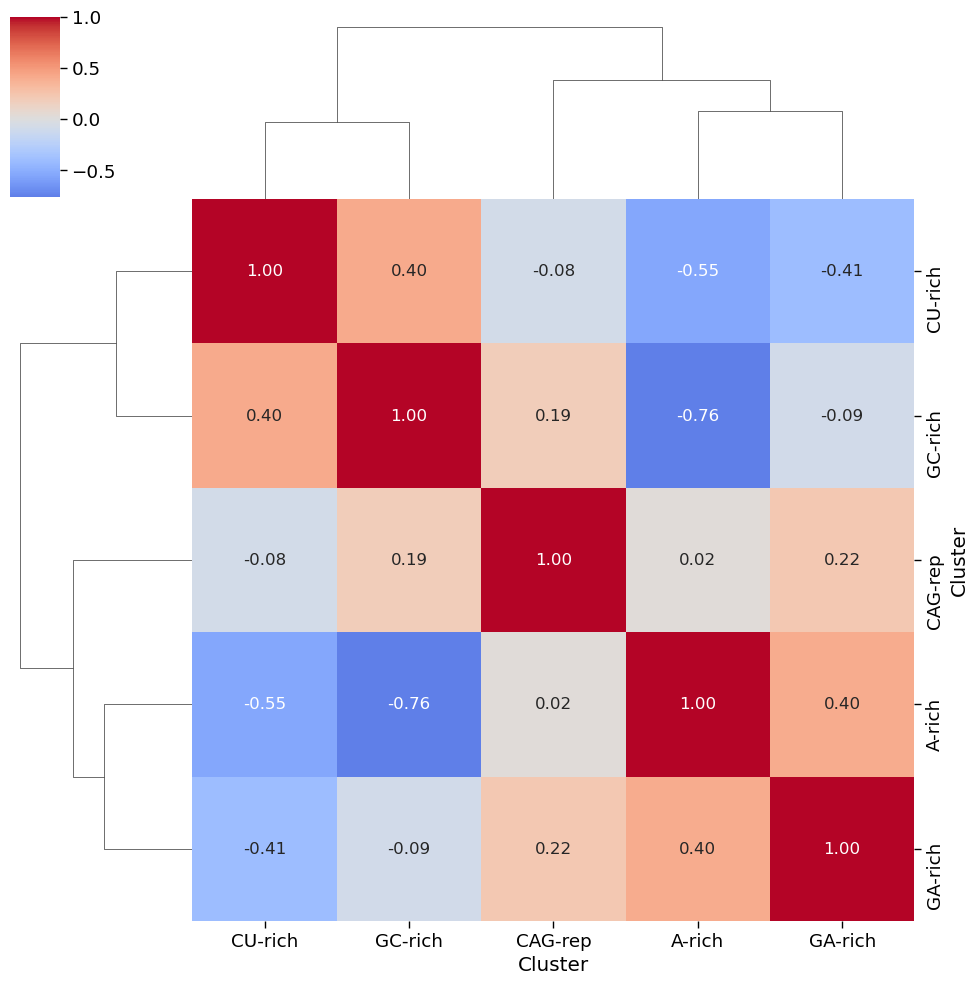

In [12]:
# Plot correlations
corr = dfSeqFeats.corr(method='spearman')
plt.figure(figsize=(12, 10))
sns.clustermap(corr, cmap='coolwarm', center=0, square=True, annot=True, annot_kws={'size': 12}, fmt=".2f")

## Combine sequence features with transcript features, remove correlated features

In [13]:
# Combine the two dataframes on index into df Feats
dfFeats = dfTxInfoIn.merge(dfSeqFeats, left_index=True, right_index=True, how='inner')
# Only keep genes that are in the dfFeats
NucCyto = NucCyto.loc[dfFeats.index, :]
# Print how many genes are in each group
print(NucCyto.groups_classes.value_counts())
# Assign a control group to genes that do not change in nuc/cyto ratio upon PPIG expression and do not fall into groups 1,1
NucCyto.loc[(NucCyto[padjCol] > pCutoff) & (NucCyto[lfcCol].abs() < ctrlmaxlfc) & (NucCyto['groups_classes'].isna()), 'groups_classes'] = 'control'
# Print how many genes are in each group
print(NucCyto.groups_classes.value_counts())

groups_classes
group1    275
group2    234
Name: count, dtype: int64
groups_classes
control    1697
group1      275
group2      234
Name: count, dtype: int64


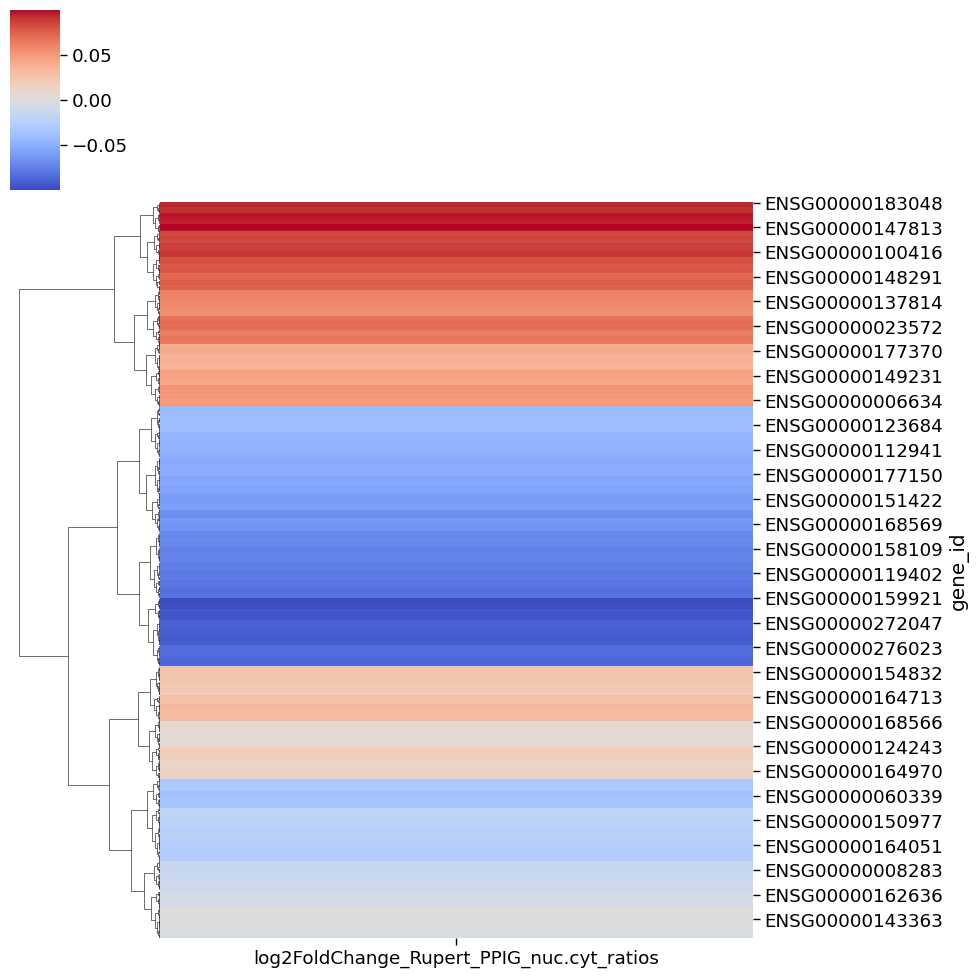

In [14]:
# Print control genes
sns.clustermap(data=NucCyto.loc[NucCyto.groups_classes == 'control', [c for c in NucCyto.columns if c.startswith("log2FoldChange_Ruper")]].fillna(0), cmap='coolwarm', col_cluster=False, center=0)

In [15]:
dfFeats.head()

,cds_length,tx_length,longest_all_exons,number_all_exons,longest_coding_exon,number_coding_exon,A-rich,CAG-rep,CU-rich,GA-rich,GC-rich
gene_id,,,,,,,,,,,
ENSG00000000003,738.0,2206.0,1317.0,8.0,189.0,7.0,-0.113790,-0.766382,-0.468040,-0.510049,-1.048433
ENSG00000000419,864.0,1161.0,370.0,10.0,161.0,10.0,0.649422,-0.636088,-0.233420,-0.225227,-0.833631
ENSG00000000971,3696.0,4127.0,394.0,22.0,203.0,22.0,0.596705,-0.536190,-0.683928,-0.154368,-0.998846
ENSG00000001036,1404.0,2356.0,1037.0,7.0,340.0,7.0,-0.380472,-0.458851,-0.803903,-0.376022,-0.259103
ENSG00000001084,1914.0,3813.0,1627.0,16.0,212.0,16.0,0.118475,-0.636261,-0.628293,0.008649,-0.812227


## Boxplot to get a sense of control group features
The plots show that sequence-independent features in a control group are distributed in between group1 and group2 as we would expect.

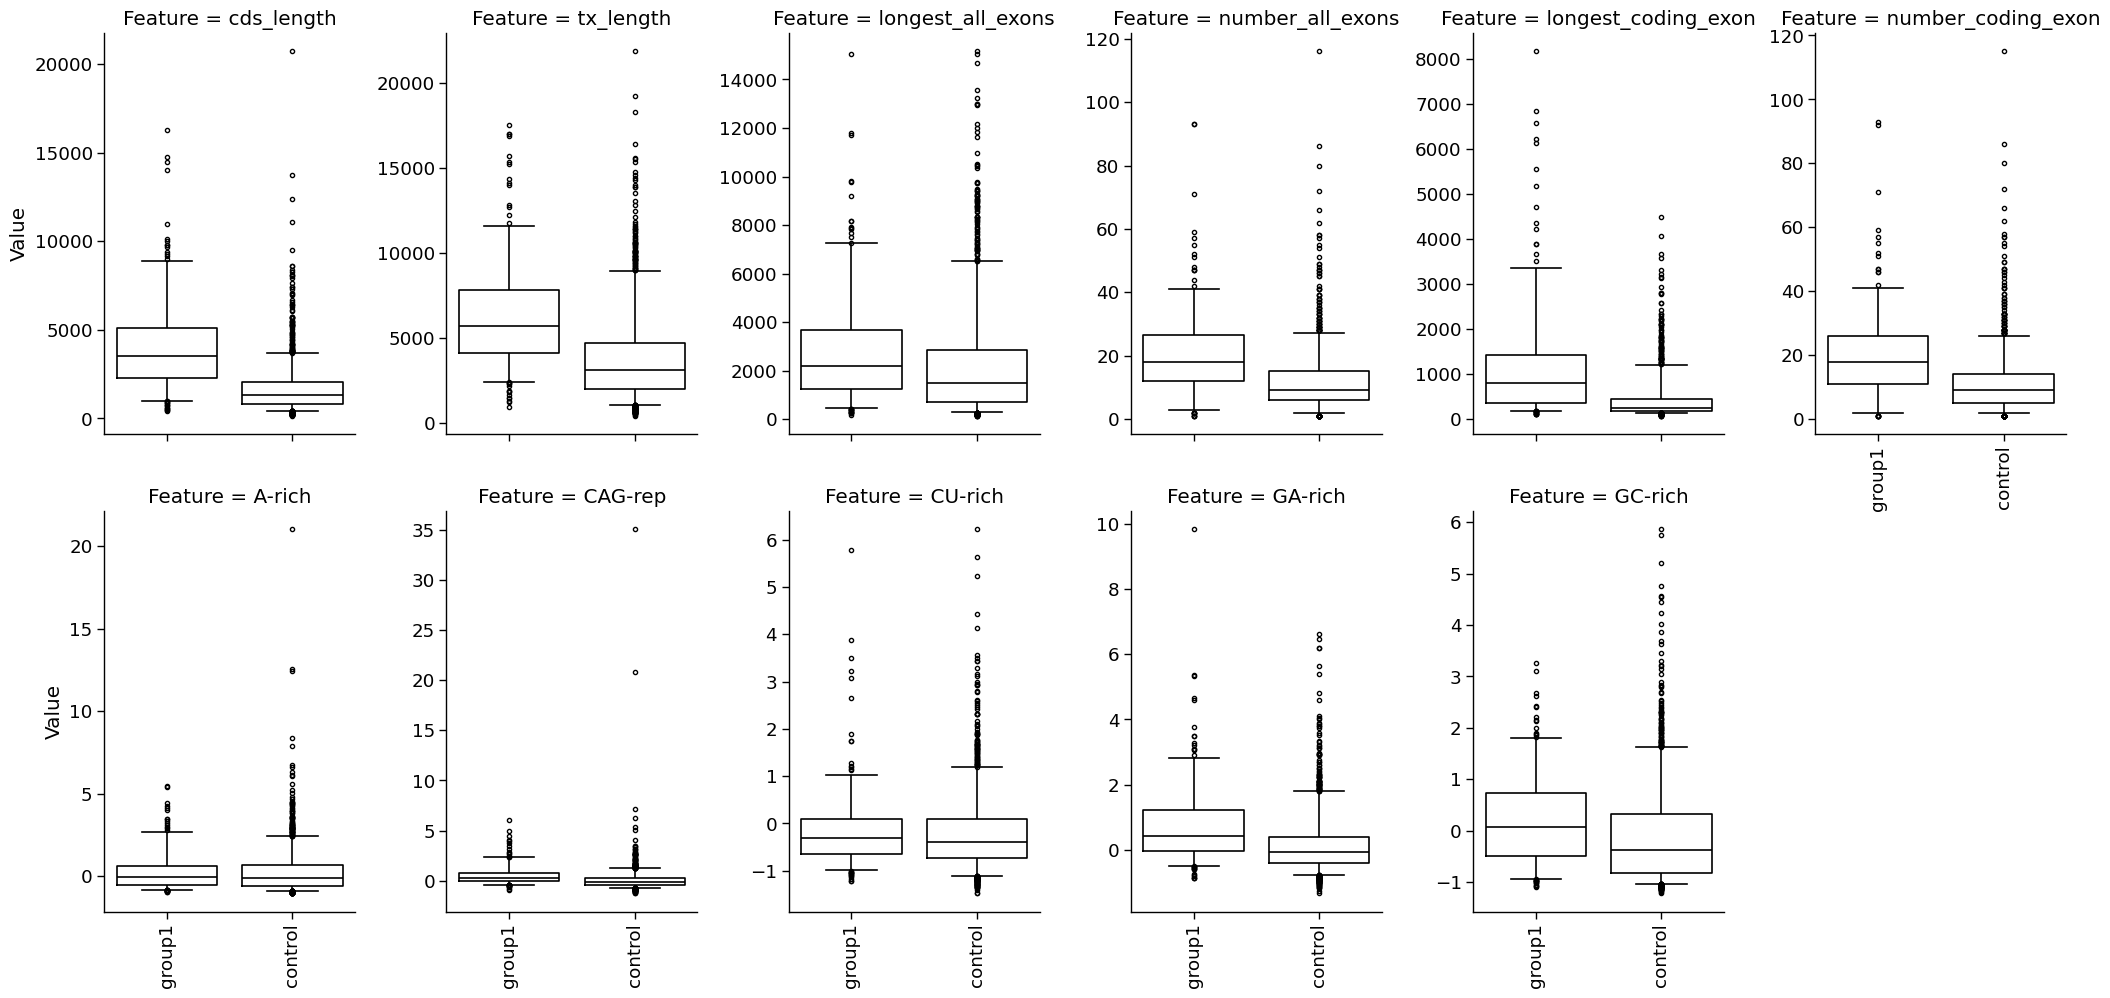

In [16]:
# Plot sequence-independent features of different groups
dfPlots = dfFeats.merge(NucCyto[['groups_classes']], left_index=True, right_index=True, how='inner')
dfPlots = dfPlots.loc[dfPlots.groups_classes.isin(['control', 'group1']), :]

groupsOrder = ['group1', 'control']

df = dfPlots.melt(id_vars=['groups_classes'], value_vars=dfFeats.columns, var_name='Feature', value_name='Value')
# Catplot, type box
g = sns.catplot(
    data=df, y='Value', col='Feature', x='groups_classes', col_wrap=6, kind='box', whis=[5, 95],
    sharey=False, aspect=.7, fill=False, margin_titles=False, color='black', order=groupsOrder, fliersize=3
    )
# Rotate x labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    # Remove x axis label
    ax.set_xlabel('')
del dfPlots

## Deal with correlated features

/home/klara/conda/envs/interstasis_paper/lib/python3.13/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1200x1200 with 0 Axes>

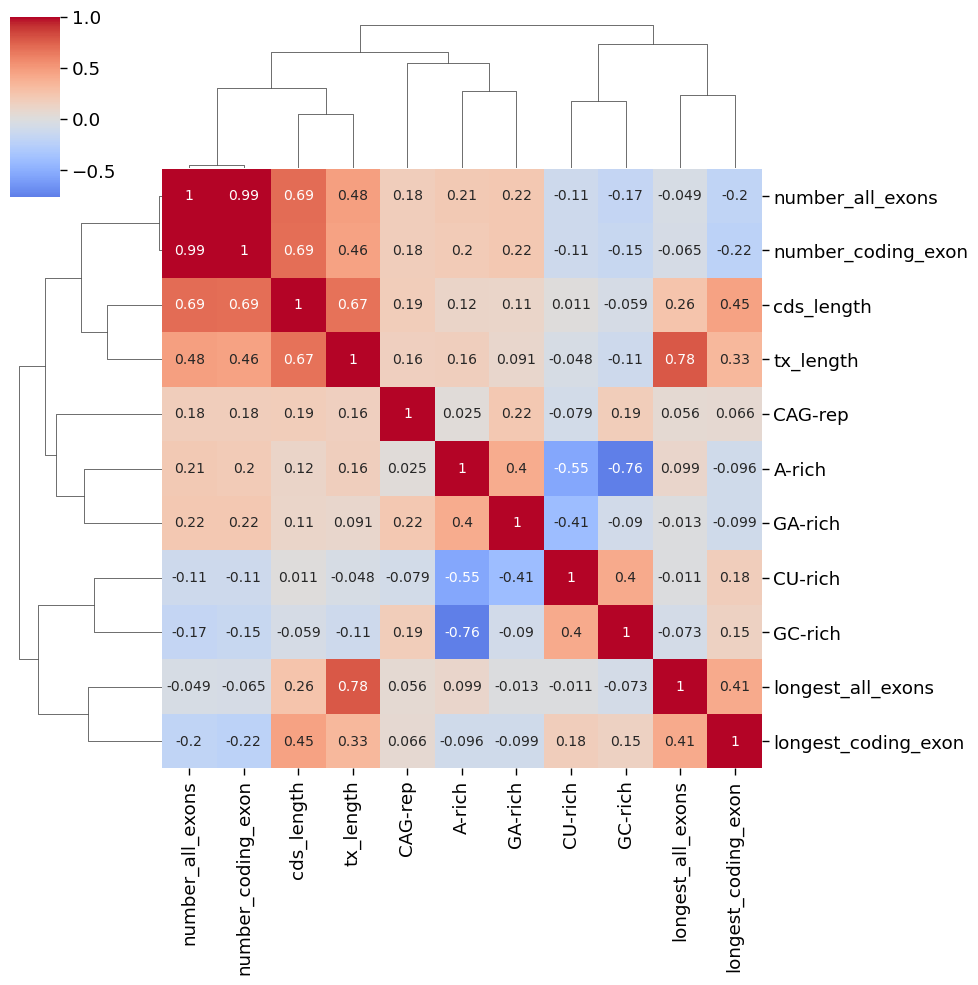

In [17]:
# Subset to training sets and check for feature correlation
allTrainingGenes = NucCyto.groups_classes.isin(['group1', 'group2', 'control']).index.tolist()
dfFeatsSubset = dfFeats.loc[allTrainingGenes, :].copy()
# Check for feature correlation
corr = dfFeatsSubset.corr(method='spearman')
# Plot the correlation matrix
plt.figure(figsize=(12, 12))
sns.clustermap(corr, cmap='coolwarm', center=0, annot=True, square=True, annot_kws={'fontsize': 10})

/home/klara/conda/envs/interstasis_paper/lib/python3.13/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


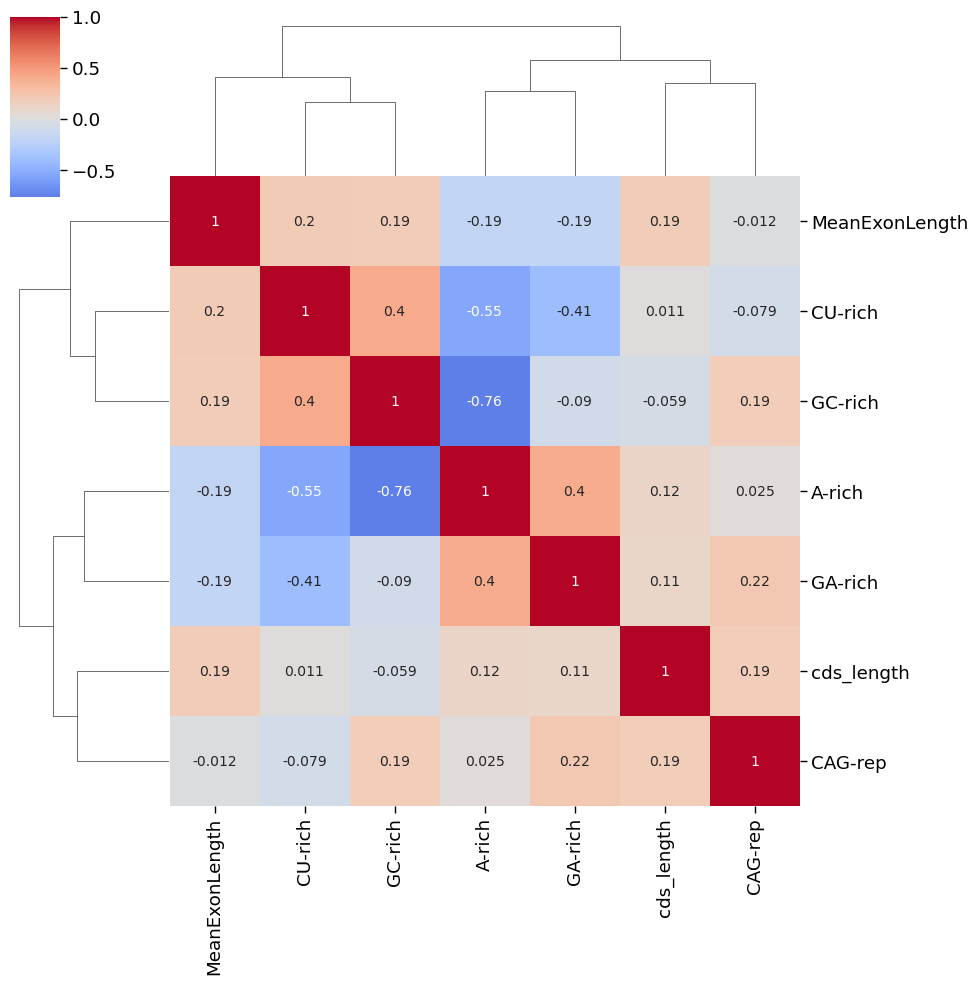

In [18]:
# Edit dfFeatures to remove highly correlated features
dfFeatsProcessed = dfFeats.copy()
# Remove highly correlated transcript info features: tx_length, number_all_exons, longest_all_exons
dfFeatsProcessed.drop(columns=['tx_length', 'number_all_exons', 'longest_all_exons'], inplace=True)
# Combine cds_length and n coding exons into a single feature - EJC-density
# dfFeatsProcessed['EJC_density'] = dfFeatsProcessed['number_coding_exon'] / dfFeatsProcessed['cds_length']
dfFeatsProcessed['MeanExonLength'] = dfFeatsProcessed['cds_length'] / dfFeatsProcessed['number_coding_exon']
# Combine longest exon and cds length feature (% CDS length)
# dfFeatsProcessed['longest_exon_cds_ratio'] = dfFeatsProcessed['longest_coding_exon'] / dfFeatsProcessed['cds_length'] # Highly correlated to EJC density
dfFeatsProcessed.drop(columns=['longest_coding_exon', 'number_coding_exon'], inplace=True)


# Check for feature correlation
corr = dfFeatsProcessed.corr(method='spearman')
# Plot the correlation matrix
g = sns.clustermap(corr, cmap='coolwarm', center=0, annot=True, square=True, annot_kws={'fontsize': 10})
# Save the figure
g.savefig(f'{outpath}FeatureCorrelationMatrix.pdf', bbox_inches='tight')

In [19]:
dfSource = dfFeatsProcessed.merge(NucCyto[['groups_classes']], left_index=True, right_index=True, how='inner')
# Convert group2 to NaN
dfSource.loc[dfSource.groups_classes == 'group2', 'groups_classes'] = np.nan
# Rename columns
colDict = {
    'groups_classes': 'Gene group',
    'cds_length': 'CDS length (nt)',
    'MeanExonLength': 'Mean exon length (nt)',
    'GC-rich': 'GC-rich multivalency (std. scaled)',
    'GA-rich': 'G-rich Pur. multivalency (std. scaled)',
    'A-rich': 'A-rich multivalency (std. scaled)',
    'CAG-rep': 'CAG-rep multivalency (std. scaled)',
    'CU-rich': 'CU-rich multivalency (std. scaled)',
}
# order columns, so that gene group is first, then sequence independent features, then multivalency features
dfSource.rename(columns=colDict, inplace=True)
colOrder = ['Gene group', 'CDS length (nt)', 'Mean exon length (nt)'] + [c for c in dfSource.columns if 'multivalency' in c]
dfSource = dfSource[colOrder].sort_values('Gene group')
# Save the dataframe
dfSource.to_csv(f'{outpath}SourceData_TranscriptFeatureTable.tsv', sep='\t', index=True)
dfSource.head()

,Gene group,CDS length (nt),Mean exon length (nt),A-rich multivalency (std. scaled),CAG-rep multivalency (std. scaled),CU-rich multivalency (std. scaled),G-rich Pur. multivalency (std. scaled),GC-rich multivalency (std. scaled)
gene_id,,,,,,,,
ENSG00000000003,control,738.0,105.428571,-0.113790,-0.766382,-0.468040,-0.510049,-1.048433
ENSG00000164219,control,1134.0,126.000000,0.067353,-0.564486,-0.172603,-0.296161,-0.747813
ENSG00000164209,control,1257.0,157.125000,-0.378597,-0.091162,0.071429,-0.573535,-0.380148
ENSG00000164187,control,2088.0,122.823529,0.873632,-0.598861,-0.063808,-0.089439,-1.070279
ENSG00000164172,control,567.0,113.400000,1.422230,-0.458546,-1.030490,0.131619,-0.943525


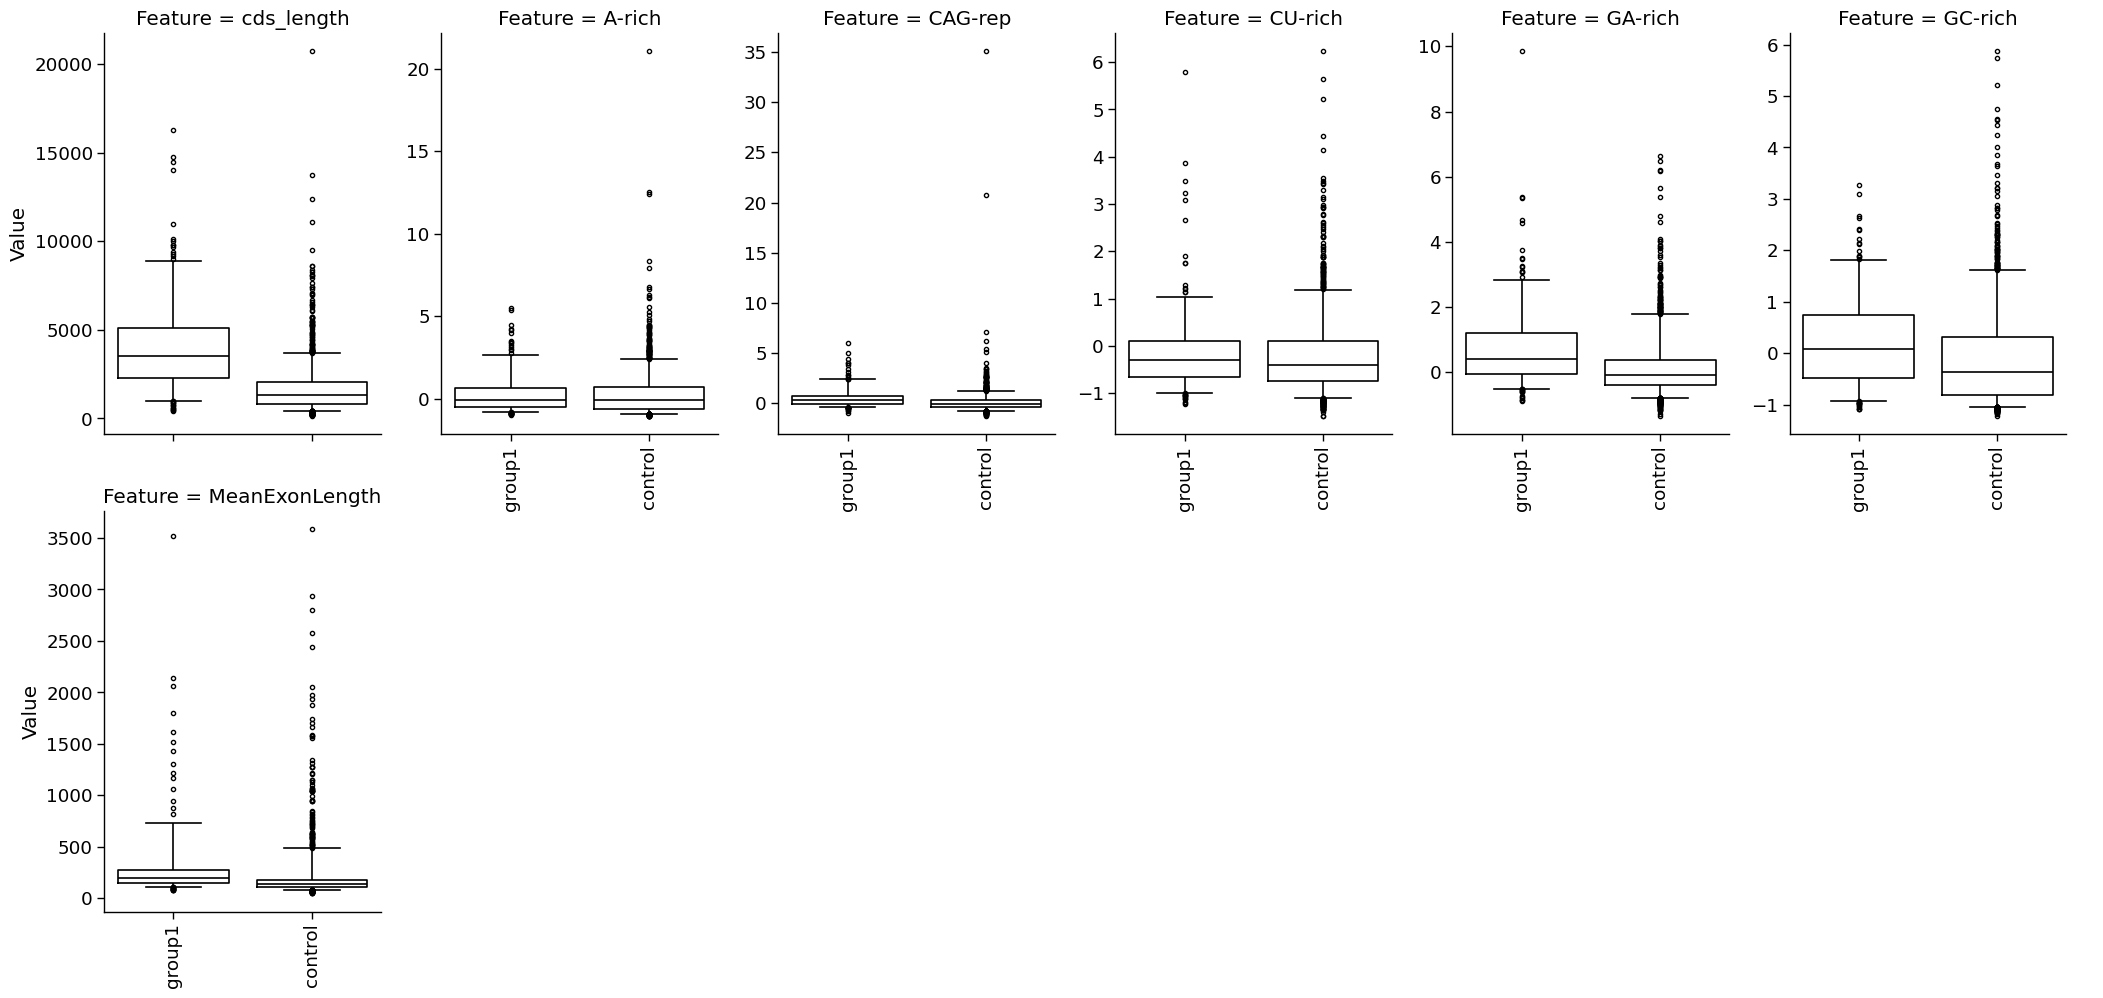

In [20]:
# Plot boxplots of processed features
# Column subtypes to plot
dfPlots = dfFeatsProcessed.merge(NucCyto[['groups_classes']], left_index=True, right_index=True, how='inner')
dfPlots = dfPlots.loc[dfPlots.groups_classes.isin(['control', 'group1']), :]

dfFeatPlot = dfPlots.melt(id_vars=['groups_classes'], value_vars=dfFeatsProcessed.columns, var_name='Feature', value_name='Value')
del dfPlots
# Catplot, type box
g = sns.catplot(
    data=dfFeatPlot, y='Value', col='Feature', x='groups_classes', col_wrap=6, kind='box', whis=[5, 95],
    sharey=False, aspect=.7, fill=False, margin_titles=False, color='black', order=groupsOrder, fliersize=3
    )
# Rotate x labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)
    # Remove x axis label
    ax.set_xlabel('')

## Modelling

Since the classes are highly imbalanced, I will train the Balanced RF classifier model.
- Using balanced RF classifier, which will repeatedly resample the majority group in a training process:
    - tried both entropy and gini criterion and both gave the same performance and feature importances

In [21]:
y1 = NucCyto.loc[NucCyto.groups_classes.isin(['group1', 'control']), 'groups_classes']
y1 = y1.map({'group1': 1, 'control': 0})
X1 = dfFeatsProcessed.loc[y1.index, :]
print(X1.head())
# Apply standard scaling by column
X1 = pd.DataFrame(StandardScaler().fit_transform(X1), columns=X1.columns, index=X1.index)
print(X1.head(), X1.shape)
y2 = NucCyto.loc[NucCyto.groups_classes.isin(['group2', 'control']), 'groups_classes']
y2 = y2.map({'group2': 1, 'control': 0})
X2 = dfFeatsProcessed.loc[y2.index, :]
X2 = pd.DataFrame(StandardScaler().fit_transform(X2), columns=X2.columns, index=X2.index)

                 cds_length    A-rich   CAG-rep   CU-rich   GA-rich   GC-rich  \
gene_id                                                                         
ENSG00000000003       738.0 -0.113790 -0.766382 -0.468040 -0.510049 -1.048433   
ENSG00000001084      1914.0  0.118475 -0.636261 -0.628293  0.008649 -0.812227   
ENSG00000002330       507.0 -0.977369  2.156015 -0.083944  0.609621  1.205669   
ENSG00000002549      1560.0  0.145104 -0.565036 -0.557987 -0.100964 -0.554315   
ENSG00000002822      2157.0 -0.314595  1.385716 -0.970544  1.968128  1.033844   

                 MeanExonLength  
gene_id                          
ENSG00000000003      105.428571  
ENSG00000001084      119.625000  
ENSG00000002330      169.000000  
ENSG00000002549      120.000000  
ENSG00000002822      126.882353  
                 cds_length    A-rich   CAG-rep   CU-rich   GA-rich   GC-rich  \
gene_id                                                                         
ENSG00000000003   -0.697378 -0.2

selected_features:  []
remaining_features:  ['cds_length', 'A-rich', 'CAG-rep', 'CU-rich', 'GA-rich', 'GC-rich', 'MeanExonLength']
Adding feature: cds_length
['cds_length']


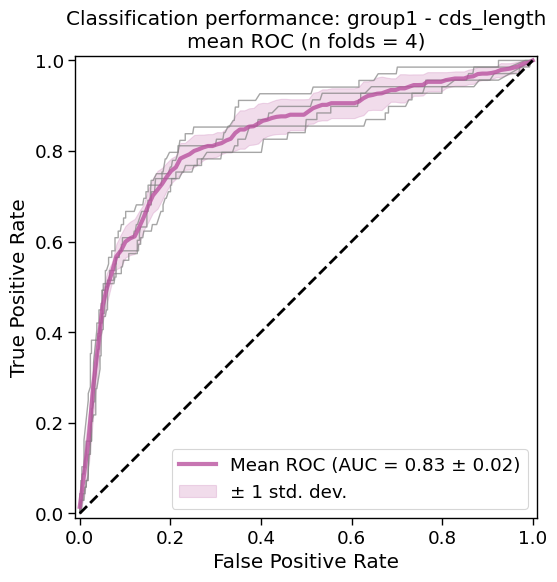

Adding feature: A-rich
['A-rich']


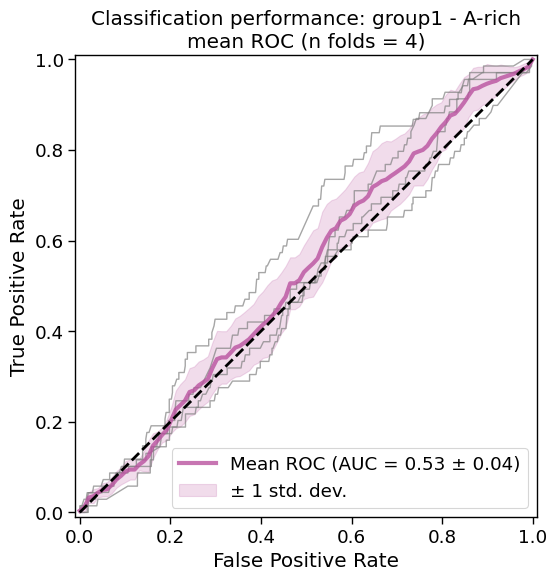

Adding feature: CAG-rep
['CAG-rep']


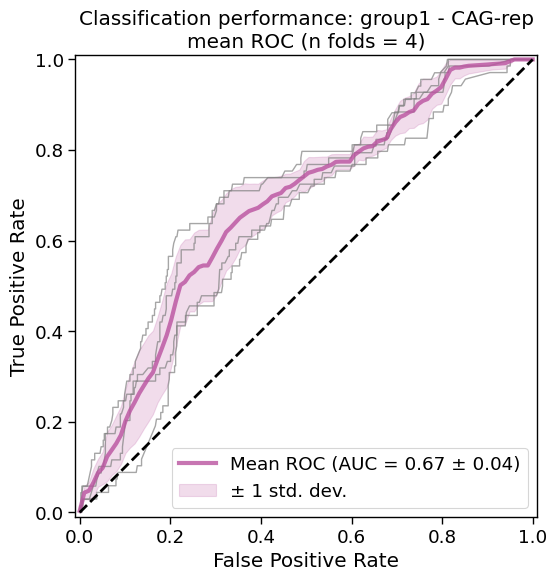

Adding feature: CU-rich
['CU-rich']


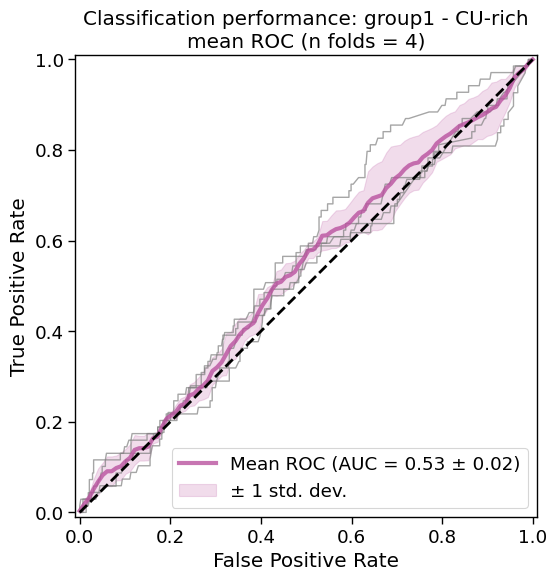

Adding feature: GA-rich
['GA-rich']


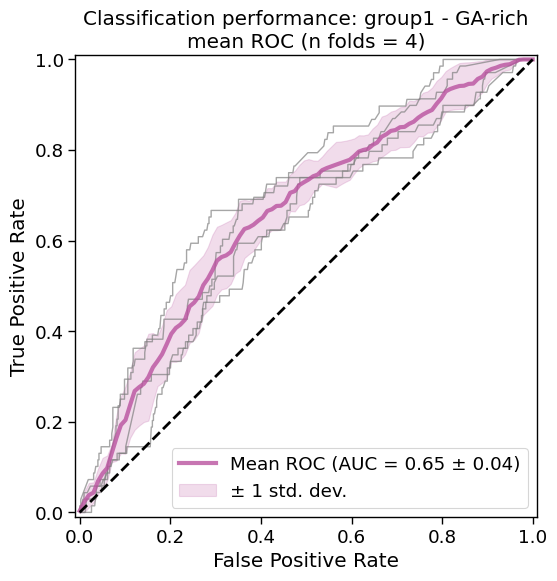

Adding feature: GC-rich
['GC-rich']


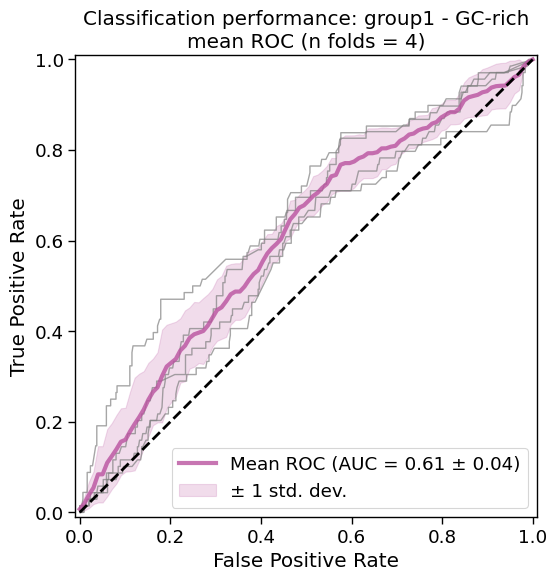

Adding feature: MeanExonLength
['MeanExonLength']


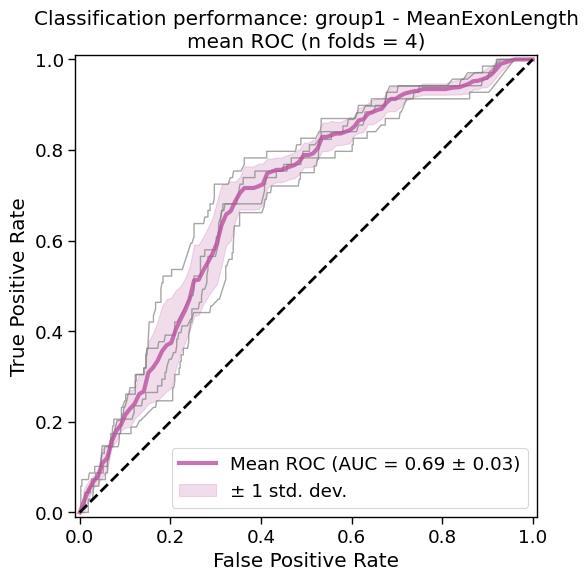

selected_features:  ['cds_length']
remaining_features:  ['CAG-rep', 'GA-rich', 'GC-rich', 'MeanExonLength']
Adding feature: CAG-rep
['cds_length', 'CAG-rep']


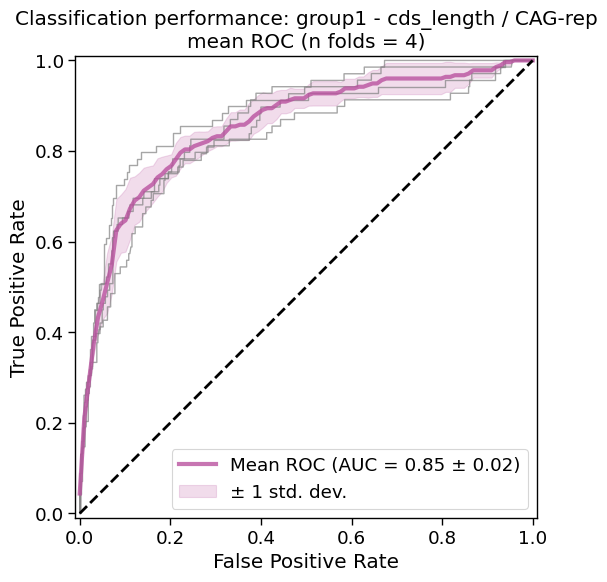

Adding feature: GA-rich
['cds_length', 'GA-rich']


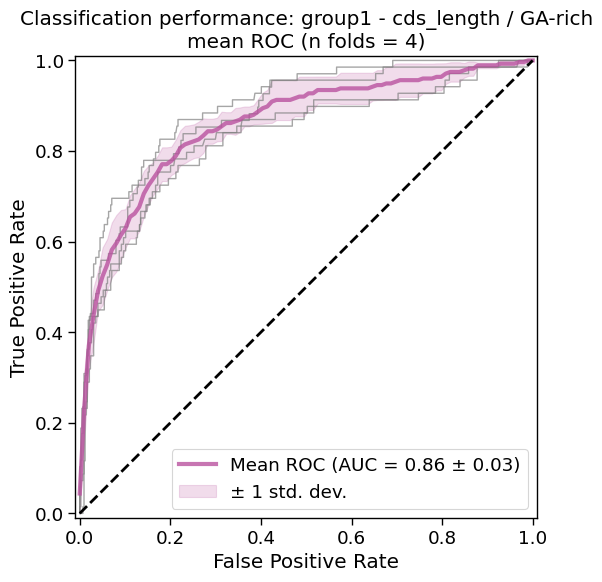

Adding feature: GC-rich
['cds_length', 'GC-rich']


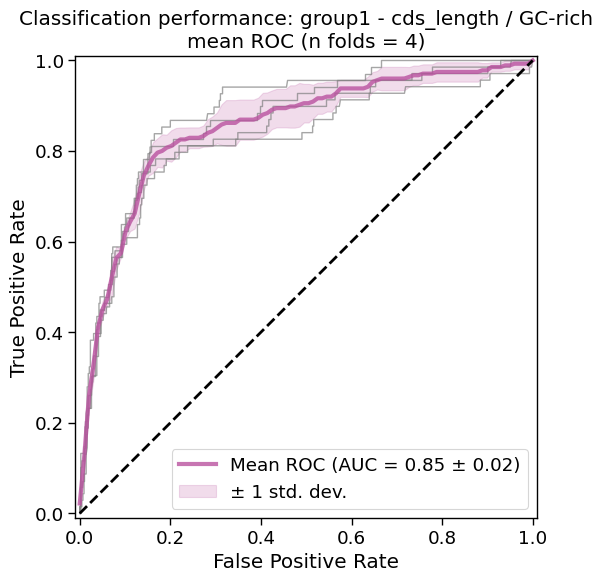

Adding feature: MeanExonLength
['cds_length', 'MeanExonLength']


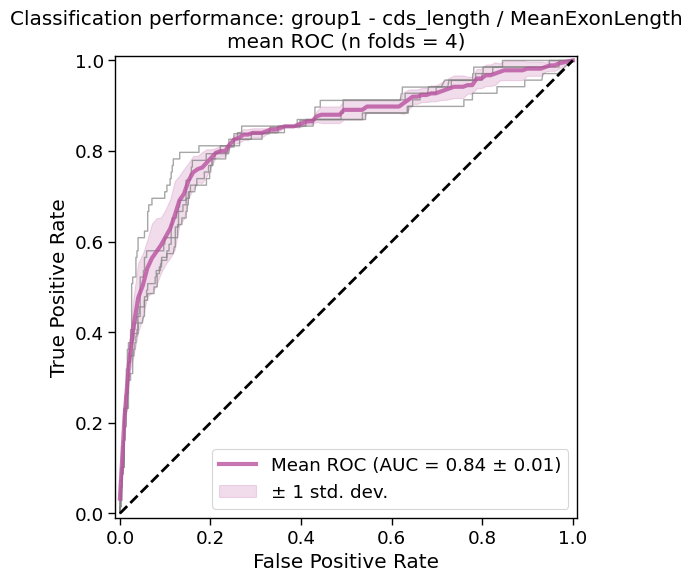

selected_features:  ['cds_length', 'GA-rich']
remaining_features:  ['CAG-rep', 'GC-rich', 'MeanExonLength']
Adding feature: CAG-rep
['cds_length', 'GA-rich', 'CAG-rep']


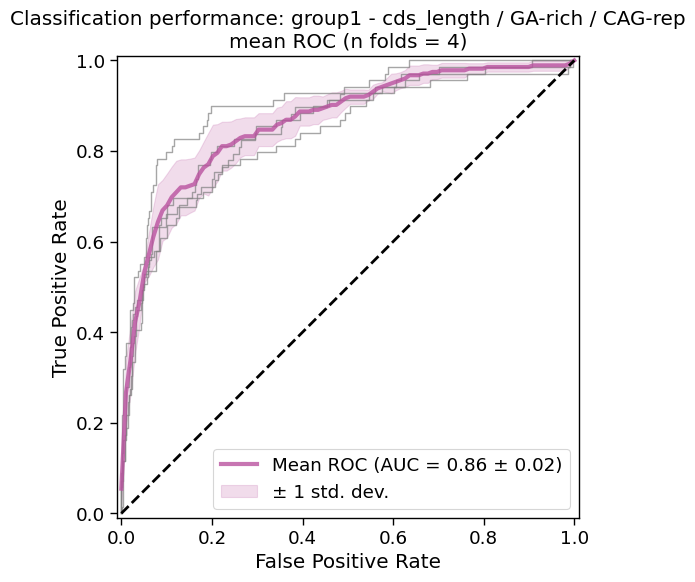

Adding feature: GC-rich
['cds_length', 'GA-rich', 'GC-rich']


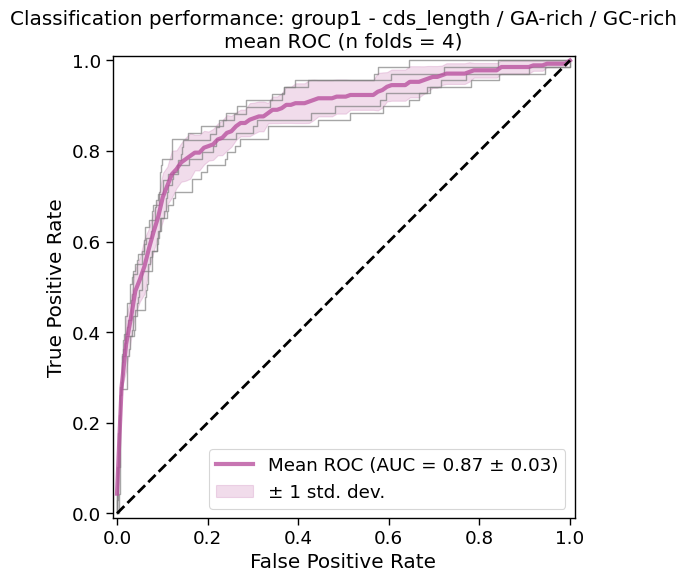

Adding feature: MeanExonLength
['cds_length', 'GA-rich', 'MeanExonLength']


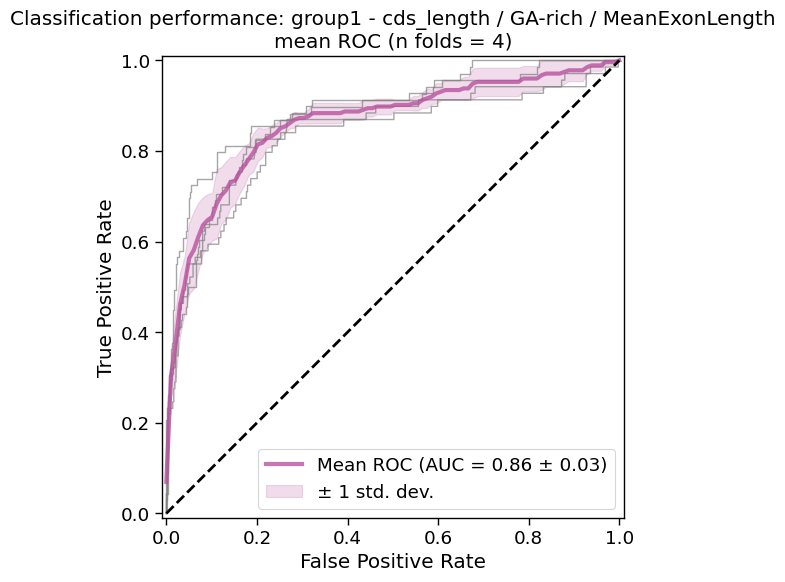

selected_features:  ['cds_length', 'GA-rich', 'GC-rich']
remaining_features:  ['CAG-rep', 'MeanExonLength']
Adding feature: CAG-rep
['cds_length', 'GA-rich', 'GC-rich', 'CAG-rep']


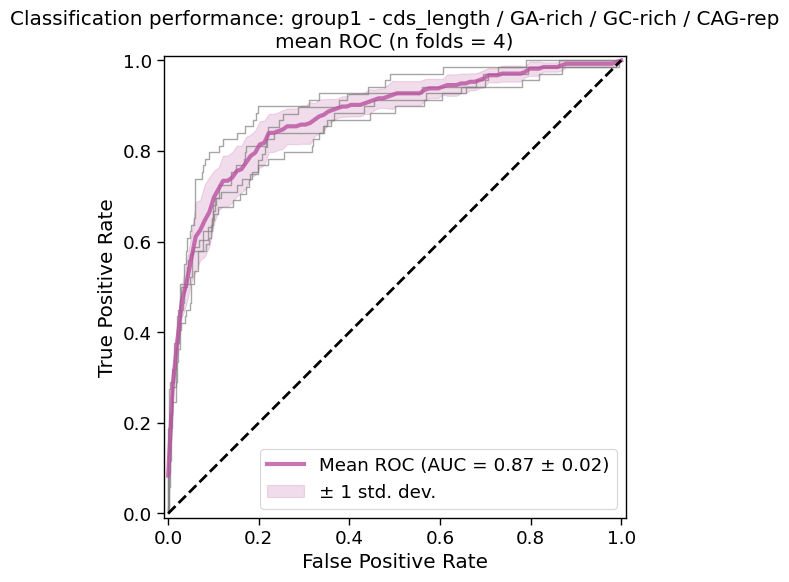

Adding feature: MeanExonLength
['cds_length', 'GA-rich', 'GC-rich', 'MeanExonLength']


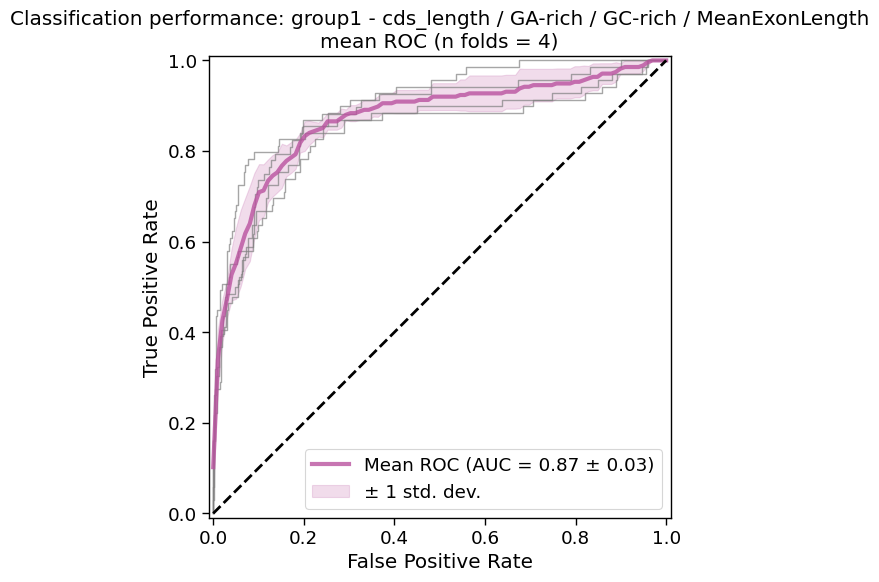

selected_features:  ['cds_length', 'GA-rich', 'GC-rich', 'CAG-rep']
remaining_features:  ['MeanExonLength']
Adding feature: MeanExonLength
['cds_length', 'GA-rich', 'GC-rich', 'CAG-rep', 'MeanExonLength']


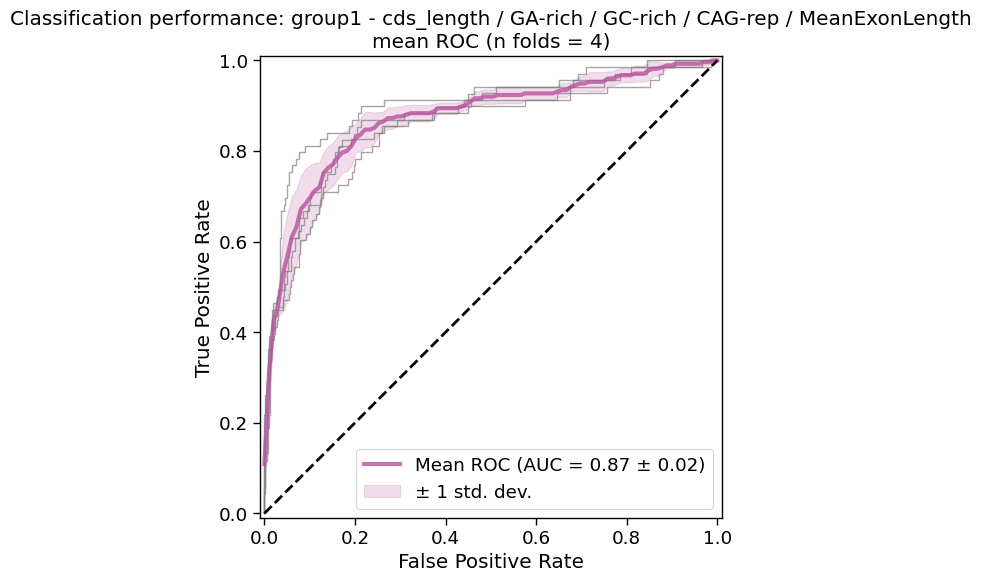

In [22]:
# Create a BalancedRandomForestClassifier
balanced_classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True, criterion='gini', replacement=True, sampling_strategy='not minority', min_samples_leaf=15)
currentAuc = 0.5
selected_features = []
remaining_features = X1.columns.tolist()
improved = True
i=1
allResults = {}
while improved:
    bestFeat, bestAuc, resultsDict = EvaluateAucImprovementWithFeatAddition(currentAuc, selected_features, remaining_features, X1, y1, balanced_classifier, 'group1', outpath=outpath, kfold=kfold)
    if bestAuc <= currentAuc:
        improved = False
    else:
        # Add results to allResults
        allResults[i] = resultsDict
        currentAuc = bestAuc
        selected_features = bestFeat
        remaining_features = [f for f in remaining_features if f not in selected_features]
        # In the first pass, remove features that result in AUC < 0.6
        if i == 1:
            remaining_features = [f for f in remaining_features if resultsDict[f]['AUC'][0] >= 0.6]
        i+=1

In [23]:
# Convert allResults to a dataframe
dfTrainingResults = pd.DataFrame.from_dict({(i, j): allResults[i][j] for i in allResults.keys() for j in allResults[i].keys()}, orient='index').reset_index()
# Rename level_0 to n_feats and level_1 to feature_set
dfTrainingResults.rename(columns={'level_0': 'n_feats', 'level_1': 'feature_set'}, inplace=True)
# Expand Accuracy, F1-score and AUC into 4 rows each (1 row per fold)
dfTrainingResults = dfTrainingResults.explode(['confusion matrices', 'Accuracy', 'F1-score', 'AUC'])
# Add a column for the fold number
dfTrainingResults['fold'] = dfTrainingResults.groupby(['n_feats', 'feature_set']).cumcount() + 1
# Convert confusin matrices to columns: tn, fp, fn, True Positive
dfTrainingResults['confusion matrices'] = dfTrainingResults['confusion matrices'].apply(lambda x: np.ravel(x))
dfTrainingResults[['True Negative', 'False Positive', 'False Negative', 'True Positive']] = pd.DataFrame(dfTrainingResults['confusion matrices'].tolist(), index=dfTrainingResults.index)
# Drop the confusion matrices column
dfTrainingResults.drop(columns='confusion matrices', inplace=True)
# Compute precision and recall (TPR)
dfTrainingResults['Precision'] = dfTrainingResults['True Positive'] / (dfTrainingResults['True Positive'] + dfTrainingResults['False Positive'])
dfTrainingResults['Recall'] = dfTrainingResults['True Positive'] / (dfTrainingResults['True Positive'] + dfTrainingResults['False Negative'])
# Compute TNR (specificity)
dfTrainingResults['Specificity'] = dfTrainingResults['True Negative'] / (dfTrainingResults['True Negative'] + dfTrainingResults['False Positive'])
# Compute balanced accuracy - useful metric for class imbalance
dfTrainingResults['BalancedAccuracy'] = (dfTrainingResults['Recall'] + dfTrainingResults['Specificity']) / 2
# Compute the average metric across folds
dfTrainingResultsAvg = dfTrainingResults.groupby(['n_feats', 'feature_set']).mean()[['BalancedAccuracy', 'F1-score', 'Precision', 'Recall', 'Specificity', 'AUC']].reset_index()

In [24]:
# Save the results as source data
dfTrainingResults.drop(columns=['Accuracy'], inplace=True)
colOrder = [c for c in dfTrainingResults.columns.tolist() if c not in ['F1-score', 'AUC']] + ['F1-score', 'AUC']
dfTrainingResults = dfTrainingResults[colOrder]
# Rename AUC to auROC
dfTrainingResults.rename(columns={'AUC': 'auROC'}, inplace=True)
# Save
dfTrainingResults.to_csv(f'{outpath}SourceData_ValidationSetPerformanceKfold.tsv', sep='\t', index=False)

In [25]:
# Printing top3 best performing models
dfTrainingResultsAvg.sort_values(by='AUC', ascending=False).head(3)

,n_feats,feature_set,BalancedAccuracy,F1-score,Precision,Recall,Specificity,AUC
14,4,cds_length / GA-rich / GC-rich / CAG-rep,0.800975,0.539389,0.411288,0.785220,0.816730,0.873185
12,3,cds_length / GA-rich / GC-rich,0.812195,0.558097,0.429770,0.796462,0.827929,0.872531
15,4,cds_length / GA-rich / GC-rich / MeanExonLength,0.812139,0.558623,0.431050,0.796355,0.827922,0.871488


# Plots for figures

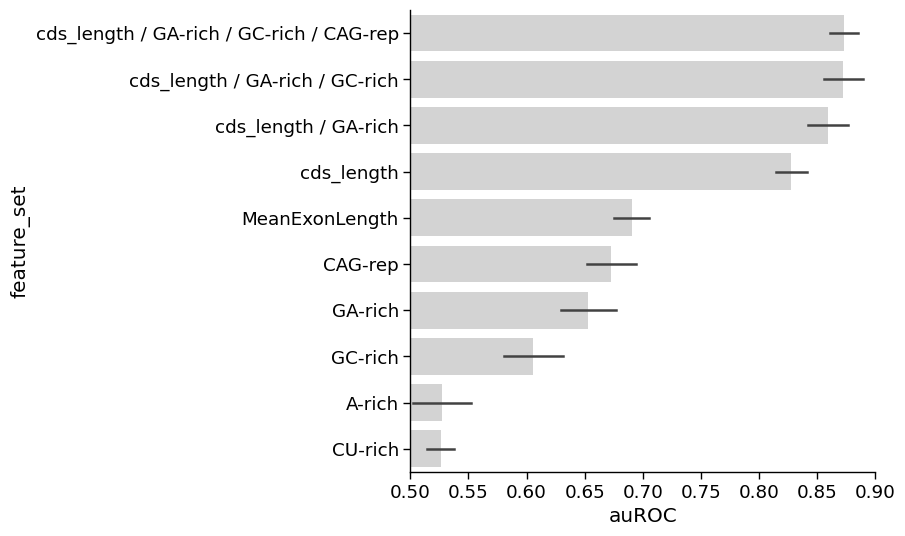

In [26]:
# Plot a barplot of AUCs starting from single features and then for the best combination
# Filter to conatain all single features and the best combination for each number of features
dfPlotMultifeat = dfTrainingResultsAvg.loc[dfTrainingResultsAvg.n_feats > 1, :].sort_values(by=['AUC', 'n_feats'], ascending=False).drop_duplicates(subset='n_feats', keep='first')
# Add single features
dfPlot = pd.concat([dfPlotMultifeat, dfTrainingResultsAvg.loc[dfTrainingResultsAvg.n_feats == 1, :]], axis=0).sort_values(by=['AUC', 'n_feats'], ascending=False)
plotFeats = dfPlot.feature_set.unique()
# Plot barplot with std error for the mean across all folds
dfTrainingResultsPlot = dfTrainingResults.copy()
dfTrainingResultsPlot = dfTrainingResultsPlot.loc[dfTrainingResultsPlot.feature_set.isin(plotFeats), :]
# Plot barplot with std error for the mean
plt.figure(figsize=(6, 6))
sns.barplot(data=dfTrainingResultsPlot, y='feature_set', x='auROC', errorbar='se', order=plotFeats, color='lightgray')
# Limit x axis 0.5-1
plt.xlim(.5, .9)
# Despine
sns.despine()
# Save pdf
plt.savefig(f'{outpath}AUC_Performance-FeatureCombinations.pdf', bbox_inches='tight')

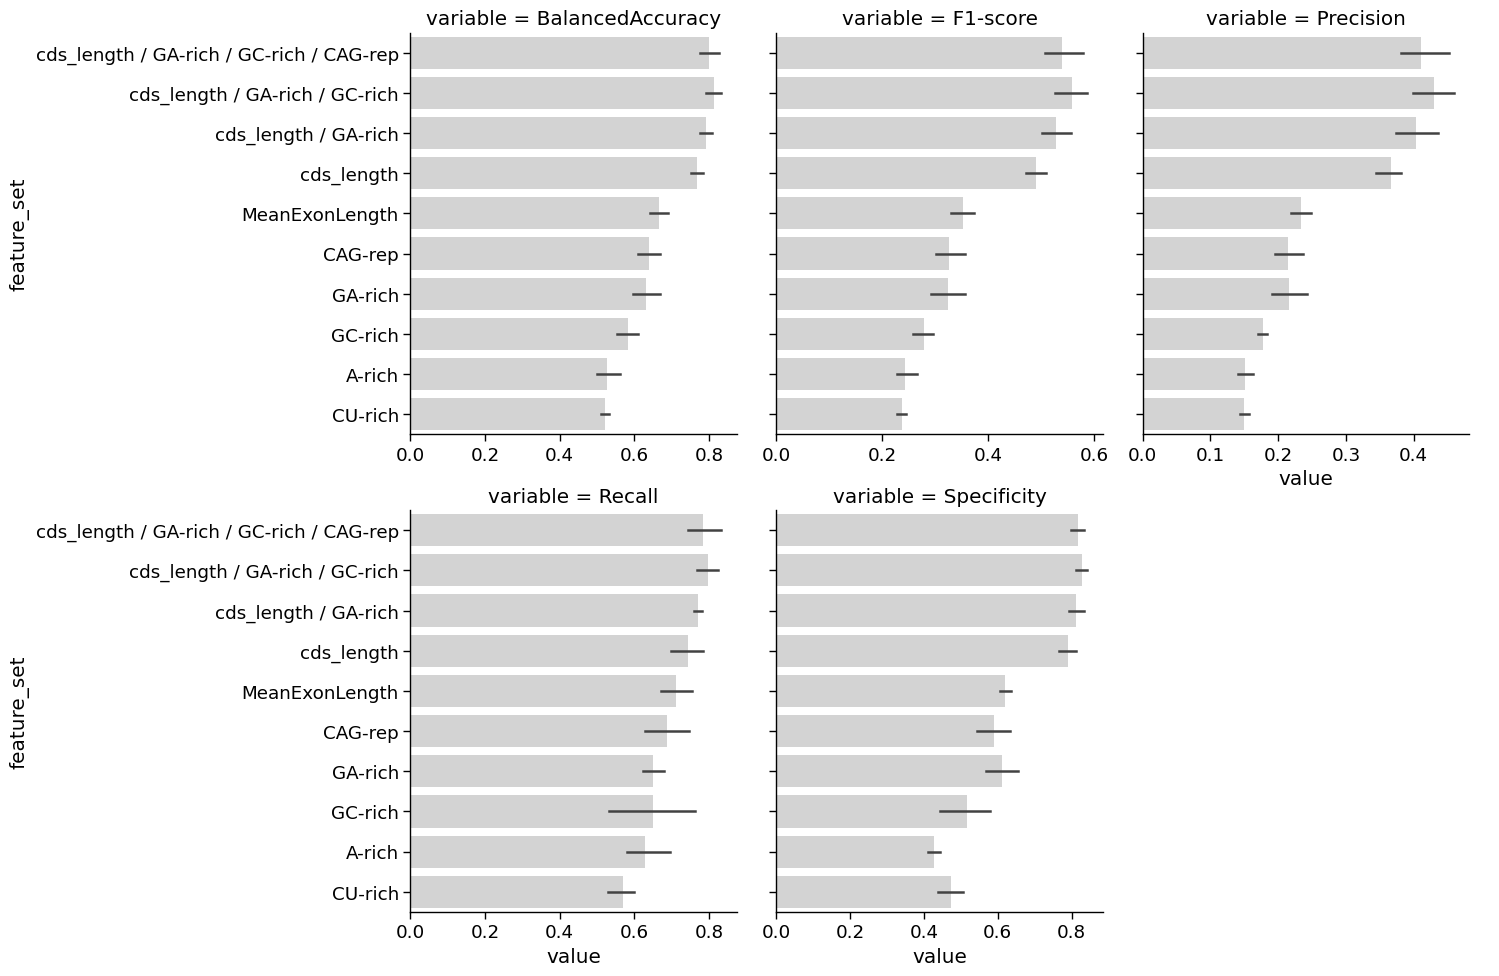

In [27]:
# Plot other performance metrics for a combination of features: BalancedAccuracy, F1-score, Precision, Recall, Specificity
dfTrainingResultsPlotMelt = dfTrainingResultsPlot.melt(id_vars=['feature_set', 'n_feats', 'fold'], value_vars=['BalancedAccuracy', 'F1-score', 'Precision', 'Recall', 'Specificity'])
# Plot barplots / catplot
g = sns.catplot(
    data=dfTrainingResultsPlotMelt, y='feature_set', x='value', col='variable',
    col_wrap=3, kind='bar', sharey=True, sharex=False, aspect=1, color='lightgray', order=plotFeats,
    )
# Save
g.savefig(f'{outpath}MiscMetrics_Performance-FeatureCombinations.pdf', bbox_inches='tight')

groups_classes
control    1697
group1      275
Name: count, dtype: int64
CDS length (nt) cds_length
Mean exon length (nt) MeanExonLength
GA-rich (std. scaled) GA-rich
CAG-repeat (std. scaled) CAG-rep


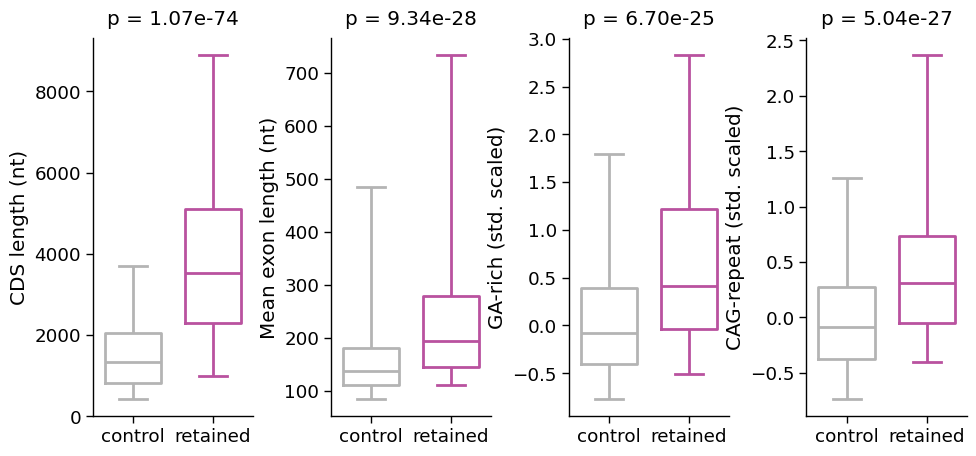

In [28]:
# Boxplot of the four main features: cds_length, MeanExonLength, G-rich Pur., CAG-repeat
df = dfFeatPlot.copy()
featOrder = ['cds_length', 'MeanExonLength', 'GA-rich', 'CAG-rep']
featLabels = ['CDS length (nt)', 'Mean exon length (nt)', 'GA-rich (std. scaled)', 'CAG-repeat (std. scaled)']
df = df.loc[(df.Feature.isin(featOrder) & df.groups_classes.isin(['group1', 'control'])), :]
# Print the number of genes in each group
print(df.loc[df.Feature=='cds_length'].groups_classes.value_counts())
# Rename group1 to retained
df['groups_classes'] = df['groups_classes'].apply(lambda x: 'retained' if x == 'group1' else x)
# Catplot, type box
g = sns.catplot(
    data=df,
    y='Value', col='Feature', x='groups_classes', kind='box', whis=[5, 95], col_order=featOrder,
    sharey=False, aspect=.5, margin_titles=False, color='black', order=['control', 'retained'], showfliers=False, width=.7, hue='groups_classes',
    legend=False, palette=['#B4B4B4', '#B9529F'], 
    linewidth=2,
    fill=False
    )

# Remove x axis label, set y axis labels
for ax, featL, feat in zip(g.axes.flat, featLabels, featOrder):
    print(featL, feat)
    ax.set_xlabel('')
    ax.set_ylabel(featL)
    ax.set_title('')
    # Add annotations - Mann-Whitney U test
    control_data = df[(df['Feature'] == feat) & (df['groups_classes'] == 'control')]['Value']
    retained_data = df[(df['Feature'] == feat) & (df['groups_classes'] == 'retained')]['Value']
    stat, p_val = stats.mannwhitneyu(control_data, retained_data)
    
    # Annotate with p-value
    annotation = f'p = {p_val:.2e}'
    ax.text(0.5, 1.05, annotation, ha='center', va='center', transform=ax.transAxes)


# Save
g.savefig(f'{outpath}Boxplot_FeatureDistributions_Stat-MWU.pdf', bbox_inches='tight')